# Smoothing Required for a Good Coarsening $P$
We expect to need smoother TVs for $P$ than for $R$.

In [61]:
%run /Users/olivne/helmholtz/src/helmholtz/startup.ipy

In [62]:
# Fixed seed for reproducible results.
np.random.seed(2)

# Domain size.
n = 96 # 192
domain_size = n   # With meshsize h = 1.
# Scaled wave number. Fit so lam_min = 0 (integer # periods in domain).
discretization = "5-point"
#kh = 0
kh = helmholtz.analysis.ideal.find_singular_kh(discretization, n)[0]
#kh = 0.5

repetitive = True

# Test vectors.
ideal_tv = False    # Use eigenvectors or not.
# Number of test vectors.  
num_examples = 5

# Set # sweeps manually here.
num_sweeps_on_vectors = 30 # 100 # None
threshold = 0.1

# Boottstrapping parameters.
interpolation_method = "ls" # "weighted_ls" #"ls"
fit_scheme = "ridge"
weighted = True
neighborhood = "extended" #"aggregate" # "extended"
num_test_examples = 5
leeway_factor = 1.3

_LOGGER.info("kh {}".format(kh))

INFO     kh 0.5233853805513013


## Level 0->1 Coarsening

In [63]:
# Create fine-level matrix.
a = hm.linalg.helmholtz_1d_discrete_operator(kh, discretization, n)
# Use default = Kacmzarz relaxation for kh != 0.
level0 = hm.setup.hierarchy.create_finest_level(a,  relaxer=hm.solve.relax.GsRelaxer(a) if kh == 0 else None)
# 'location' is an array of variable locations at all levels. Used only for interpolation neighbor determination.
# Finest-level variable ocations are assumed to be [0..n-1], i.e. a domain of size n with meshsize h = 1.
level0.location = np.arange(n)

### Coarsening

In [64]:
def create_coarsening(level, nu, aggregate_size, num_components):
    # Generate relaxed test vectors.
    x = hm.setup.auto_setup.get_test_matrix(level.a, nu, num_examples=num_examples)
    _LOGGER.info("Generating relaxed TF with {} sweeps, RER {:.3f}".format(nu, norm(level.a.dot(x)) / norm(x)))
    #x_log.append(x)

    # Create coarsening. Force 2 coarse vars per aggregate so we can test alignment.
    r, s = hm.repetitive.locality.create_coarsening(x, aggregate_size, num_components, normalize=False)
    R = r.tile(level.size // aggregate_size)
    return x, R

In [65]:
# Check Relaxation smoothing.
num_sweeps = hm.setup.auto_setup.check_relaxation_speed(0, level0)[1]
aggregate_size, num_components = 4, 2
x, R = create_coarsening(level0, 2 * num_sweeps, aggregate_size, num_components)

INFO     level 0 size 96 relax conv 0.93 shrinkage 0.64 PODR RER 0.55 after 5 sweeps. Work 1.0 eff 0.64
INFO     Generating relaxed TF with 10 sweeps, RER 0.312


### Interpolation Performance vs. #TF Sweeps

In [82]:
def two_level_performance(level, num_sweeps: int, num_tf_sweeps: np.ndarray,
                           aggregate_size, num_components):
    num_cycle_sweeps = np.arange(1, num_sweeps + 3)
    
    for nu in num_tf_sweeps:
        if nu == -1:
            print("Eigenvector TFs")
            x = hm.analysis.ideal.ideal_tv(level.a, num_examples)[0]
        else:
            print("#TF sweeeps", nu)
            x = hm.setup.auto_setup.get_test_matrix(level.a, nu, num_examples=num_examples)
        
        r, s = hm.repetitive.locality.create_coarsening(x, aggregate_size, num_components, normalize=False)
        R = r.tile(level.size // aggregate_size)
        # TODO: replace by local mock cycle rate.
        mock_conv = np.array([hm.setup.auto_setup.mock_cycle_conv_factor(level, R, nu) for nu in num_cycle_sweeps])

        p_experiment = {}
        l2c_experiment = {}
        coarsening_values = (False, True)
        titles = ("P^T A P", "R A P")
        conv = pd.DataFrame(mock_conv.transpose(), index=num_cycle_sweeps, columns=("Mock", )).transpose()
        for use_r_as_restriction, title in zip(coarsening_values, titles):
            calibers = (2, 4) # if use_r_as_restriction else (2, 4)
            l2c = []
            p_caliber = []
            for caliber in calibers:
                #print("caliber", caliber)

                p = hm.setup.auto_setup.create_interpolation(
                    x, level.a, R, level.location, domain_size, interpolation_method, aggregate_size=aggregate_size, num_components=num_components, 
                    neighborhood=neighborhood, repetitive=repetitive, target_error=0.1,
                    caliber=caliber, fit_scheme=fit_scheme, weighted=weighted)
                #print("p row sums", np.array(p.sum(axis=1)).flatten()[:5])

                ml = hm.repetitive.locality.create_two_level_hierarchy_from_matrix(
                        level.a, level.location, R, p, aggregate_size, num_components,
                            use_r_as_restriction=use_r_as_restriction)
                ac = ml[1].a
                fill_in_factor = (ac.nnz / ml[0].a.nnz) * (ml[0].a.shape[0] / ac.shape[0])
                symmetry_deviation = np.max(np.abs(ac - ac.transpose()))
                two_level_conv = np.array([
                    hm.repetitive.locality.two_level_conv_factor(
                        ml, nu, print_frequency=None)[1]
                     for nu in num_cycle_sweeps])
                l2c.append([use_r_as_restriction, caliber, p.nnz, fill_in_factor, symmetry_deviation] + list(two_level_conv))
                p_caliber.append(p)

            p_experiment[use_r_as_restriction] = p_caliber
            l2c_experiment[use_r_as_restriction] = l2c

        all_conv = pd.DataFrame(np.array(
            [[np.nan] * 5 + list(mock_conv)] +
            [v for use_r_as_restriction in coarsening_values for v in l2c_experiment[use_r_as_restriction]]), 
                            columns=("R A P", "Caliber", "nnz(P)", "Fill-in", "Symmetry") + tuple(num_cycle_sweeps), 
                                index=("Mock", ) + tuple("{} caliber {}".format(title, caliber) for title in titles
                                  for caliber in calibers))
        styler = all_conv.style.set_caption("Convergence Factors").format(precision=2)
        display_html(styler._repr_html_(), raw=True)
    return p_experiment

In [96]:
num_tf_sweeps = np.concatenate(([0], 2 ** np.arange(1, 7)))
p_experiment = two_level_performance(level0, num_sweeps, num_tf_sweeps, aggregate_size, num_components)

#TF sweeeps 0


,R A P,Caliber,nnz(P),Fill-in,Symmetry,1,2,3,4
Mock,nan,nan,nan,nan,nan,0.92,0.90,0.90,0.84
P^T A P caliber 2,0.00,2.00,192.00,1.20,0.00,3.09,2.26,2.72,2.49
P^T A P caliber 4,0.00,4.00,384.00,2.00,0.00,1.40,1.26,1.34,1.36
R A P caliber 2,1.00,2.00,192.00,1.20,0.09,7.74,4.26,6.26,5.43
R A P caliber 4,1.00,4.00,384.00,1.20,0.11,2.75,1.66,2.10,1.81


#TF sweeeps 2


,R A P,Caliber,nnz(P),Fill-in,Symmetry,1,2,3,4
Mock,nan,nan,nan,nan,nan,0.62,0.30,0.27,0.33
P^T A P caliber 2,0.00,2.00,192.00,1.20,0.00,8.01,11.31,11.55,10.62
P^T A P caliber 4,0.00,4.00,384.00,2.00,0.00,282.76,389.41,378.71,333.28
R A P caliber 2,1.00,2.00,192.00,1.20,0.26,2.29,2.46,2.36,2.31
R A P caliber 4,1.00,4.00,384.00,1.20,0.09,3.64,4.83,4.88,4.59


#TF sweeeps 4


,R A P,Caliber,nnz(P),Fill-in,Symmetry,1,2,3,4
Mock,nan,nan,nan,nan,nan,0.70,0.37,0.24,0.17
P^T A P caliber 2,0.00,2.00,192.00,1.20,0.00,2.71,4.02,4.06,3.65
P^T A P caliber 4,0.00,4.00,384.00,2.00,0.00,0.60,0.32,0.18,0.20
R A P caliber 2,1.00,2.00,192.00,1.20,0.18,5.18,6.18,6.78,7.05
R A P caliber 4,1.00,4.00,384.00,1.20,0.04,1.38,1.42,1.49,1.54


#TF sweeeps 8


,R A P,Caliber,nnz(P),Fill-in,Symmetry,1,2,3,4
Mock,nan,nan,nan,nan,nan,0.60,0.32,0.18,0.14
P^T A P caliber 2,0.00,2.00,192.00,1.20,0.00,0.51,0.35,0.45,0.46
P^T A P caliber 4,0.00,4.00,384.00,2.00,0.00,0.61,0.31,0.16,0.13
R A P caliber 2,1.00,2.00,192.00,1.20,0.03,0.52,0.35,0.42,0.45
R A P caliber 4,1.00,4.00,384.00,1.20,0.03,0.76,0.46,0.23,0.22


#TF sweeeps 16


,R A P,Caliber,nnz(P),Fill-in,Symmetry,1,2,3,4
Mock,nan,nan,nan,nan,nan,0.57,0.33,0.18,0.15
P^T A P caliber 2,0.00,2.00,192.00,1.20,0.00,0.54,0.34,0.46,0.46
P^T A P caliber 4,0.00,4.00,384.00,2.00,0.00,0.60,0.33,0.18,0.13
R A P caliber 2,1.00,2.00,192.00,1.20,0.05,0.53,0.36,0.45,0.48
R A P caliber 4,1.00,4.00,384.00,1.20,0.01,0.66,0.32,0.22,0.19


#TF sweeeps 32


,R A P,Caliber,nnz(P),Fill-in,Symmetry,1,2,3,4
Mock,nan,nan,nan,nan,nan,0.60,0.32,0.20,0.17
P^T A P caliber 2,0.00,2.00,192.00,1.20,0.00,0.54,0.37,0.44,0.47
P^T A P caliber 4,0.00,4.00,384.00,2.00,0.00,0.59,0.34,0.22,0.13
R A P caliber 2,1.00,2.00,192.00,1.20,0.04,0.52,0.46,0.50,0.51
R A P caliber 4,1.00,4.00,384.00,1.20,0.02,0.70,0.44,0.31,0.23


#TF sweeeps 64


,R A P,Caliber,nnz(P),Fill-in,Symmetry,1,2,3,4
Mock,nan,nan,nan,nan,nan,0.61,0.34,0.20,0.15
P^T A P caliber 2,0.00,2.00,192.00,1.20,0.00,0.54,0.39,0.48,0.49
P^T A P caliber 4,0.00,4.00,384.00,2.00,0.00,0.60,0.32,0.22,0.14
R A P caliber 2,1.00,2.00,192.00,1.20,0.07,0.58,0.37,0.47,0.50
R A P caliber 4,1.00,4.00,384.00,1.20,0.01,0.68,0.39,0.29,0.22


Looks like a $P^T A P$ gives good rated with with only $4$ TF sweeps. $8$ are required to get a good $R A P$. So we could possibly benefit from a bootstrap step, although the overhead might not even be justified here.

### Create Level 1

In [77]:
# Pick an interpolation operator P:1->0 to work with. We use a high-order (caliber 4) P.
#p = p_experiment[True][-1]  # R*A*P P high order
p = p_experiment[True][-1]  # R*A*P P high order, near-symmetric here.

m0 = hm.repetitive.locality.create_two_level_hierarchy_from_matrix(
    level0.a, level0.location, R, p, aggregate_size, num_components, use_r_as_restriction=True)

## Level 1->2
Loading a 6-point stencil obtained by 4/2 coarsening of level 0 from file.

In [78]:
a1 = scipy.sparse.load_npz('level_1_operator.npz')
level1 = hm.setup.hierarchy.create_finest_level(a1)
level0_location = np.arange(2 * a1.shape[0]) #level0.location
level1.location = hm.setup.geometry.coarse_locations(level0_location, aggregate_size, num_components)
pd.DataFrame(a1.todense()[4:6, np.unique(a1[4:6].nonzero()[1])])

,0,1,2,3,4,5
0,0.15,-0.19,-0.03,-0.05,0.15,0.14
1,0.15,-0.16,-0.04,-0.63,-0.19,-0.16


### Coarsening

In [79]:
# Check Relaxation smoothing.
num_sweeps = hm.setup.auto_setup.check_relaxation_speed(0, level1)[1]
aggregate_size, num_components = 4, 2
x, R = create_coarsening(level1, 30 * num_sweeps, aggregate_size, num_components)

INFO     level 0 size 48 relax conv 0.92 shrinkage 0.43 PODR RER 0.20 after 2 sweeps. Work 1.0 eff 0.43
INFO     Generating relaxed TF with 60 sweeps, RER 0.012


,0,1,2,3,4,5,6,7,8,9
0,0.77,-0.07,-0.43,0.47,0.00,0.00,0.00,0.00,0.00,0.00
1,-0.15,0.78,-0.59,-0.16,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.77,-0.07,-0.43,0.47,0.00,0.00
3,0.00,0.00,0.00,0.00,-0.15,0.78,-0.59,-0.16,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.77,-0.07


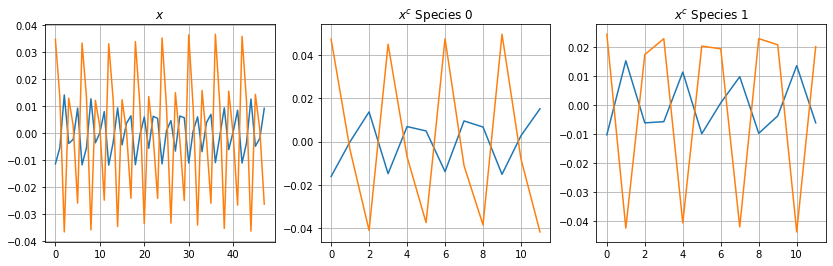

In [80]:
xc = R.dot(x)
display(pd.DataFrame(R[:5,:10].todense()))
hm.repetitive.locality.plot_coarsening(R, x)

### Interpolation Performance vs. #TF Sweeps

In [85]:
#num_tf_sweeps = np.concatenate(([0], 2 ** np.arange(1, 10)))
#num_tf_sweeps = np.concatenate(([0], 2 ** np.arange(1, 10), [-1]))
num_tf_sweeps = [8]
p_experiment = two_level_performance(level1, 10, num_tf_sweeps, aggregate_size, num_components)

#TF sweeeps 8
[array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1])]
[array([ 0,  1, 22, 23]), array([ 0,  1, 22, 23]), array([0, 1, 2, 3]), array([0, 1, 2, 3])]
[array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1])]
[array([ 0,  1, 22, 23]), array([ 0,  1, 22, 23]), array([0, 1, 2, 3]), array([0, 1, 2, 3])]


,R A P,Caliber,nnz(P),Fill-in,Symmetry,1,2,3,4,5,6,7,8,9,10,11,12
Mock,nan,nan,nan,nan,nan,0.31,0.37,0.30,0.26,0.22,0.18,0.15,0.11,0.10,0.09,0.08,0.08
P^T A P caliber 2,0.00,2.00,96.00,1.00,0.00,2.87,2.05,1.78,1.50,1.26,1.06,1.00,1.05,1.06,1.04,1.06,1.06
P^T A P caliber 4,0.00,4.00,192.00,1.67,0.00,1.61,0.37,0.37,0.34,0.35,0.35,0.35,0.35,0.35,0.35,0.35,0.35
R A P caliber 2,1.00,2.00,96.00,1.00,0.05,1.97,1.48,1.25,1.07,0.92,0.98,0.97,1.01,1.02,1.02,1.02,1.02
R A P caliber 4,1.00,4.00,192.00,1.00,0.05,1.14,1.13,1.13,1.13,1.13,1.13,1.13,1.13,1.13,1.13,1.13,1.13


* Here we require $32$ sweeps to get a good $P^T A P$, and $64$ to get a good $R A P$. So bootstrap is definitely beneficial. 
* Note that there is "relaxing too much": past $100$ sweeps, the 2-level convergence degrades. Some degeneration in the TFs likely.
* Also, $R A P$ becomes less symmetric then. This happens with both weighted/unweighted LS fitting.
* Mock cycle rates stabilize after $4-8$ relaxations.

## Notes
* A lot of samples with small # TF sweeps still gives us a good R because we have a large sample size for SVD.
* Ideal vectors work: $P^T A P$ with high order $P$ is good. $R A P$ is OK. So relaxing to the limit is fine, provided the vectors are orthogonalized.

## TODO

* Try ideal vectors.
* Do relaxations to generate an initial $P$.
* Bootstrap is for identifying slow-to-converge components and improve $P$ for them.
* $8$ TF sweeps only - what is the initial cycle rate? Does it have good shrinkage? Even if asymptotic rate is bad.
* Compare first mock cycle rates vs. 2-level cycle rates.
* Check if divergence is because the last cycles ar bad but before were good.
* Add orthogonalization / Ritz projection - does the result improve with more relax sweeps then?
* Do we need to regularize?
* Try larger domain, at which # relax does the problem start? Is it domain size dependent?

In [88]:
p = p_experiment[True][-1]

<48x24 sparse matrix of type '<class 'numpy.float64'>'
	with 192 stored elements in Compressed Sparse Row format>

INFO         0 |r| 3.332e+00 RER 0.85032
INFO         1 |r| 4.681e-01 (0.14046) RER 0.09133 (0.10740) 5.125
INFO         2 |r| 8.708e-02 (0.18603) RER 0.01947 (0.21315) 4.473
INFO         3 |r| 2.195e-02 (0.25204) RER 0.00514 (0.26418) 4.268
INFO         4 |r| 6.256e-03 (0.28503) RER 0.00148 (0.28701) 4.238
INFO         5 |r| 2.030e-03 (0.32457) RER 0.00048 (0.32395) 4.246
INFO         6 |r| 7.111e-04 (0.35021) RER 0.00017 (0.35000) 4.249
INFO         7 |r| 2.526e-04 (0.35518) RER 0.00006 (0.35528) 4.248
INFO         8 |r| 9.234e-05 (0.36560) RER 0.00002 (0.36566) 4.247
INFO         9 |r| 3.427e-05 (0.37117) RER 0.00001 (0.37117) 4.247
INFO        10 |r| 1.287e-05 (0.37549) RER 0.00000 (0.37548) 4.247
INFO        11 |r| 4.818e-06 (0.37441) RER 0.00000 (0.37441) 4.247
INFO        12 |r| 1.782e-06 (0.36981) RER 0.00000 (0.36981) 4.247
INFO        13 |r| 6.756e-07 (0.37914) RER 0.00000 (0.37914) 4.247
INFO        14 |r| 2.485e-07 (0.36780) RER 0.00000 (0.36780) 4.247
INFO        15 |r| 9.

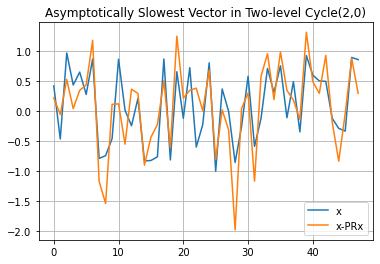

In [95]:
# TODO(orenlivne): define error as (x-x0) projected onto range(a).
nu = 2
use_r_as_restriction = False
p = p_experiment[use_r_as_restriction][-1]  # P^T*A*P P high order
use_r_as_restriction = use_r_as_restriction

m1 = hm.repetitive.locality.create_two_level_hierarchy_from_matrix(
    level1.a, level1.location, R, p, aggregate_size, num_components, use_r_as_restriction=use_r_as_restriction)

y, _ = hm.repetitive.locality.two_level_conv_factor(m1, nu, print_frequency=1,
                                                    debug=False)

# Asymptotic vector.
plt.title("Asymptotically Slowest Vector in Two-level Cycle({},0)".format(nu))
# y -= y.mean() # Remove zero component.
e = y - m1[1].p.dot(m1[1].r.dot(y))
plt.plot(y, label="x");
plt.plot(e, label="x-PRx");
plt.grid(True);
plt.legend();